In [1]:
import dabench as dab
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
from rc import RCModel

# Define data generator

In [2]:
# First define data generator and generate data
nature_run = dab.data.Lorenz96(system_dim=6, delta_t=0.01, store_as_jax=True)

In [3]:
nature_run.generate(n_steps=10000)

# Define model

In [4]:
our_model = RCModel(system_dim=6, 
                reservoir_dim=1600, 
                input_dim=6, 
                sparse_adj_matrix=False, 
                sparsity=0.99,
                readout_method='linear',
                sigma=0.07,
                spectral_radius = 0.1, 
                leak_rate=0.7,
                log_beta=-18.41)

In [5]:
our_model.weights_init()

In [6]:
our_model.generate(nature_run.values, save_states=True)

In [7]:
our_model.train(nature_run)

In [8]:
out_obj = our_model.predict(nature_run, delta_t = 0.01, n_steps = 1200, initial_index=0, spinup_steps=1)

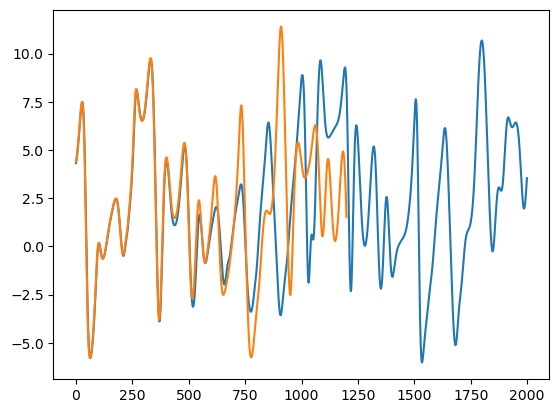

In [9]:
plt.plot(nature_run.values[:2000, 0])
plt.plot(out_obj.values[:2000, 0])

In [10]:
class RCModelForecaster(dab.model.Model):                                                                       
    """Defines model wrapper for RC Model"""
    def forecast(self, state_vec):
        new_vals = self.model_obj.update(state_vec.values, self.model_obj.readout(state_vec.values))      

        new_vec = dab.vector.StateVector(values=new_vals, store_as_jax=True)

        return new_vec

In [11]:
forecast_model = RCModelForecaster(model_obj=our_model)

# Generate observations

In [12]:
# Now we can define the observer:
obs_l96 = dab.observer.Observer(
    nature_run, # Data generator object
    time_indices = np.arange(0, 10000, 5), # Observation every other timestep
    random_location_count = 6, # Probability of picking each location in l63.system_dim for random sampling
    error_bias = 0.0, # Mean for observation error, Gaussian/Normal distribution
    error_sd = 0.5, # Standard deviation for observation error, Gaussian/Normal distribution
    random_seed=91, # We can specify a random seed. Default is 99
    stationary_observers=True,
    store_as_jax=True
)

# Making observations
obs_vec_l96 = obs_l96.observe()

# Define ObsOp

In [13]:
S = jnp.zeros((12, 6))
S = S.at[jnp.arange(S.shape[0]), np.tile(obs_vec_l96.location_indices[0], 2)
             ].set(1)
H = S @ our_model.Wout.T

# Define DA Cycler

In [14]:
dc = dab.dacycler.ETKF(system_dim=our_model.reservoir_dim,#nature_run.system_dim, # 6
                   delta_t=nature_run.delta_t,
                   H=H,
                   model_obj=forecast_model, # Forecast model we created above
                   ensemble_dim=10 # Ensemble dim for Ensemble Kalman Filter
                  )


# Run DA Cycler

In [15]:
%%time

cur_tstep = 1000

in_ensemble_sys = nature_run.values[cur_tstep-1] + np.random.normal(size=(10, 6), scale=1)
in_ensemble_res = jnp.stack(
    [our_model.update(our_model.states[cur_tstep-1], in_ensemble_sys[i]) for i in range(in_ensemble_sys.shape[0])])

# ETKF input state is an ensemble with error
etkf_x0 = dab.vector.StateVector(
    values=in_ensemble_res,
    store_as_jax=True)

# Run cycler for 3000 timesteps
out_statevec = dc.cycle(
    input_state = etkf_x0,
    start_time = nature_run.times[cur_tstep],
    obs_vector = obs_vec_l96,
    obs_error_sd = 1.0,
    analysis_window=0.1, 
    timesteps=4000)

CPU times: user 1min 4s, sys: 2.23 s, total: 1min 6s
Wall time: 1min 3s


# Plot

In [16]:
# Transform to system space:
out_statevals = np.zeros((out_statevec.time_dim, out_statevec.values.shape[1], 6))
for i in range(out_statevec.values.shape[0]):
    for j in range(out_statevec.values.shape[1]):
        out_statevals[i, j] = our_model.readout(jnp.array(out_statevec.values[i,j]))

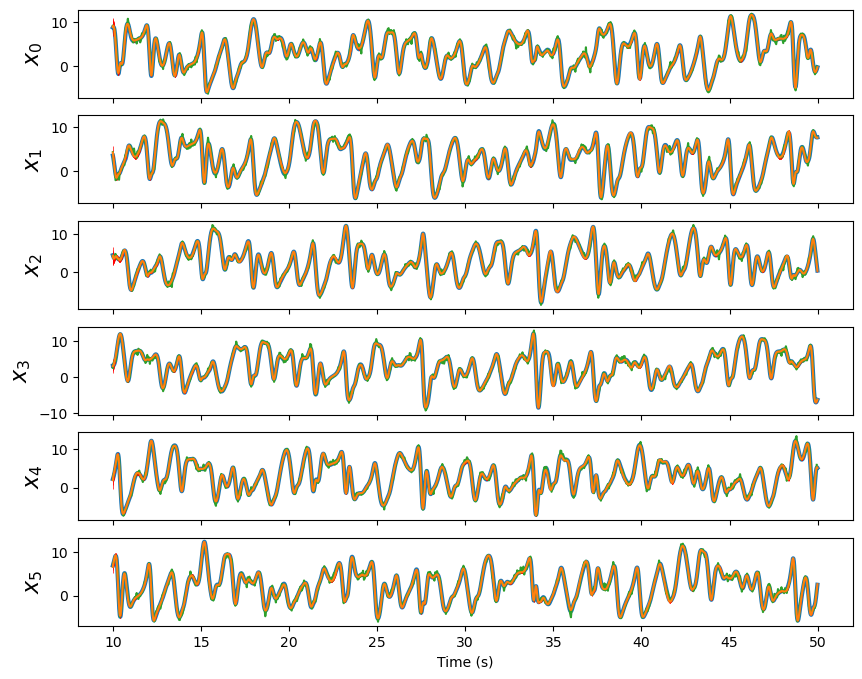

In [17]:
fig, axes = plt.subplots(6, 1, sharex = True, figsize = (10, 8))
for j, ax in enumerate(axes):
    ax.plot(out_statevec.times[:4000], nature_run.values[1000:5000,j], lw = 3, label = 'True')
    ax.errorbar(out_statevec.times[:4000], np.mean(out_statevals, axis=1)[:4000,j],
                yerr=np.ptp(out_statevals, axis=1)[:4000,j], elinewidth=0.5, ecolor='red')
    if j in obs_vec_l96.location_indices[0]:
        ax.plot(obs_vec_l96.times[200:1000], obs_vec_l96.values[200:1000, np.where(j == obs_vec_l96.location_indices[0])[0]])
    ax.set_ylabel(r'$x_{:d}$'.format(j), fontsize = 16)
ax.set_xlabel('Time (s)')
plt.show()

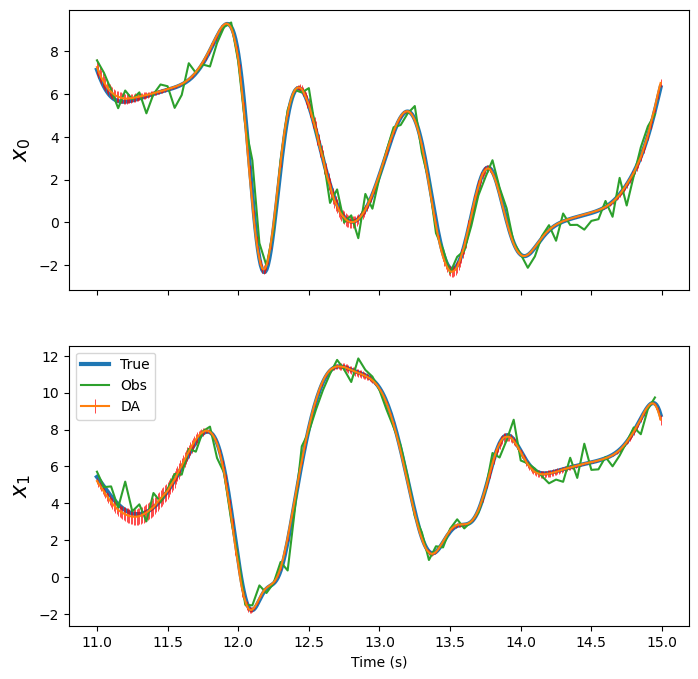

In [18]:
# Zoom in a bit to see the error more clearly
fig, axes = plt.subplots(2, 1, sharex = True, figsize = (8, 8))
for j, ax in enumerate(axes):
    ax.plot(out_statevec.times[100:500], nature_run.values[1100:1500,j], lw = 3, label = 'True')
    ax.errorbar(out_statevec.times[100:500], np.mean(out_statevals, axis=1)[100:500,j],
                yerr=np.ptp(out_statevals, axis=1)[100:500,j], elinewidth=0.5, ecolor='red', label='DA')
    ax.set_ylabel(r'$x_{:d}$'.format(j), fontsize = 16)
    if j in obs_vec_l96.location_indices[0]:
        ax.plot(obs_vec_l96.times[220:300], obs_vec_l96.values[220:300, np.where(j == obs_vec_l96.location_indices[0])[0]], label='Obs')
ax.set_xlabel('Time (s)')
axes[1].legend()
plt.show()